# HOMEWORK 3: Designing Closed Loop Systems

This homework involves designing a closed loop system with a PID controller.

## Preliminaries

In [1]:
!pip -q install controlSBML
import controlSBML as ctl
import control
from controlSBML.util import makeSimulationTimes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import tellurium as te
import sympy
print("controlSBML version: " + ctl.__version__)

     |████████████████████████████████| 357 kB 36.1 MB/s 
     |████████████████████████████████| 8.8 MB 58.6 MB/s 
     |████████████████████████████████| 154 kB 65.6 MB/s 
     |████████████████████████████████| 438 kB 62.3 MB/s 
     |████████████████████████████████| 6.8 MB 44.1 MB/s 
     |████████████████████████████████| 121 kB 65.3 MB/s 
     |████████████████████████████████| 342 kB 84.7 MB/s 
     |████████████████████████████████| 428 kB 86.0 MB/s 
     |████████████████████████████████| 54 kB 3.3 MB/s 
     |████████████████████████████████| 561 kB 82.0 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 130 kB 87.0 MB/s 
     |████████████████████████████████| 80 kB 10.6 MB/s 
     |████████████████████████████████| 133 kB 79.2 MB/s 
     |████████████████████████████████| 103 kB 80.2 MB/s 
     |████████████████████████████████| 250 kB 84.3 MB/s 
     |████████████████████████████████| 57 kB 5.9 MB/s 
     |███████████████

## BIOMD823

In [2]:
# Use the local file if it's available
BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

In this homework, you will design a closed loop system for controlling pDEPTOR in the mTOR system as modelled in BioModels 823.
Use pAkt as the control input.
1. **Build**. (4 pt) Implement the function ``evaluateDesign`` that evaluates the control design of
a closed loop system for mTOR.
The evaluation is in the form of a plot of the step response of the system
to a change in the reference input.
The plot should include the reference input along with the pAkt and pDEPTO
values for the closed loop mTOR system. The function has as inputs the design parameters kp, ki, kd.
1. **Design**. (2 pt) Use ``evaluateDesign`` to design a system that has no bias for a unit step response in the reference and settles within 10 seconds.
1. **Analysis**. (3 pt) Construct the transfer function
for mTOR from pAkt to pDEPTOR
and the transfer function $H_{NY} (s)$ for the design parameters you used in (2)
(Obtain the Jacobian at time 1 from the open loop mTOR system.)
Use these transfer functions to answer the following questions about how the closed loop system should behave *in theory*.
   1. Why are large control inputs required to control the mTOR system?
   1. Why are there no long term oscillations in the closed loop system?
   1. How will a step increase in noise affect the output of the closed loop system?
1. **Discussion**. (1 pt) Plot the values of pAkt for the closed loop system you designed in (2).
What issues do you see with using this closed loop system in practice?

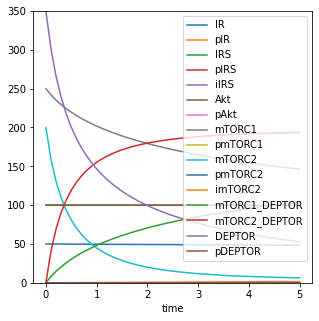

In [3]:
ctlsb = ctl.ControlSBML(BIOMD823)
ctlsb.plotTrueModel(figsize=(5,5))

In [31]:
TIMES = ctl.makeSimulationTimes(0, 25, 500)

In [5]:
(ctlsb.state_names)

['IR',
 'pIR',
 'IRS',
 'pIRS',
 'iIRS',
 'Akt',
 'pAkt',
 'mTORC1',
 'pmTORC1',
 'mTORC2',
 'pmTORC2',
 'imTORC2',
 'mTORC1_DEPTOR',
 'mTORC2_DEPTOR',
 'DEPTOR',
 'pDEPTOR']

# Helpers

In [6]:
def plotTFs(Gs, kp=0, ki=0, kd=0, times=TIMES, ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    kp: float
    ki: float
    kd: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0])  \
        + control.TransferFunction([kd, 0], [1])
    Fs = 1
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=times, U=1)
        plt.plot(result.t.flatten(), result.y.flatten())
    # Refine plots
    plt.legend(list(tf_dct.keys()))
    xmax = max(result.t.flatten())
    plt.plot([0, xmax], [0, 0], linestyle="--", color="black")
    plt.plot([0, xmax], [1, 1], linestyle="--", color="grey")
    plt.ylim([-5, 5])
    title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
    plt.title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, kp=10, ylim=[0, 3], title="Example", is_plot=False)
assert(len(dct) == 4)
assert("TransferFunction" in str(type(dct["HRYs"])))
print("OK!")

OK!


In [16]:
def makeHRY(model, tf, input_name, output_name, time=0, kp=0, ki=0, kd=0):
    """
    Calculates the transfer function from the reference input to the output.
    
    Parameters
    ----------
    model: str
    tf: string
      transfer function name that you want returned
    input_name: str
    output_name: str
    time: float
    kp: float
    ki: float
    kd: float
    
    Returns
    -------
    control.TransferFunction
    """
    ctlsb = ctl.ControlSBML(model, input_names=[input_name], output_names=[output_name])
    Gs = ctlsb.makeTransferFunction(time=time)
    dct = plotTFs(Gs, kp=kp, ki=ki, kd=kd, is_plot=False)
    return dct[tf]
    
    
# TESTS
tf = makeHRY(BIOMD823, "HRYs","pAkt", "pDEPTOR", time=0,kp=0)
assert(tf.dcgain() == 0)
print("OK!")


OK!


TransferFunction(array([0.]), array([1.]))

In [9]:
def plotPIDStepResponse(kp=1, ki=0, kd=0, is_plot=True):
    """
    Plots the step response of the PID controller.
    
    Parameters
    ----------
    kp: float
    ki: float
    kd: float
    is_plot: bool
    
    Returns
    -------
    control.TransferFunction
    """
    tf = control.TransferFunction([kp], [1])  \
          + control.TransferFunction([ki], [1, 0])  \
          + control.TransferFunction([kd, 0], [1])
    if is_plot:
        if len(tf.num[0][0]) > len(tf.den[0][0]):
            print("Improper transfer function. Cannot simulate.")
        else:
            result = control.step_response(tf)
            plt.plot(result.t.flatten(), result.y.flatten())
    return tf

# Tests
tf = plotPIDStepResponse(kp=1, ki=0, kd=0, is_plot=False)
assert(tf.dcgain() == 1)
print("OK!")

OK!


# Q1. Build

control.iosys.InterconnectedSystem

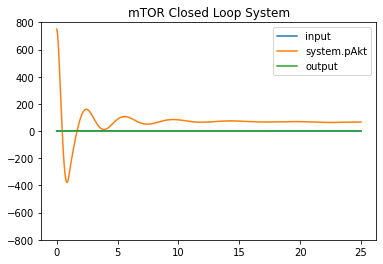

In [36]:
def evaluateDesign (model=BIOMD823, input_name="pAkt", output_name="pDEPTOR", kp=0, ki=0, kd=0, title="mTOR Closed Loop System"):
  '''
  Evaluates the control design of a closed loop system for mTOR in the form of 
  a plot of the step response of the system to a change in the reference
  input

  Parameters
  ----------
  model: str
        System under control
  input_name: str
  output_name: str
  kp: float
  ki: float
  kd: float
  title: string

  Returns
  -------
  control.InterconnectedSystem

  '''
  # Creating the closed loop system elements
  factory = ctl.IOSystemFactory()
  ctlsb = ctl.ControlSBML(BIOMD823, input_names=[input_name], output_names=[output_name])
  system = ctlsb.makeNonlinearIOSystem("system")
  controller = factory.makePIDController("controller", kp=kp, ki=ki, kd=kd)
  sum_R_S = factory.makeAdder("sum_R_S")
 

  # Creating the closed loop system test bed

  # Create the closed loop system
  system_in = "system.%s" % input_name
  system_out = "system.%s" % output_name
  '''
  #names = ['%s' % n for n in ctlsb.state_names
           #if not n in ctlsb.input_names]
  connections = []
  for name in names:
    new_connection = ["controller." + name, "system." + name]
    connections.append(new_connection)
  connections.append([system_in, "controller.out"],)
  '''
  closed_loop = control.interconnect(
    [sum_R_S, system, controller ], 
    connections=[
      ['controller.in', 'sum_R_S.out'],    # e(t)
      [system_in,   'controller.out'],   # u(t)
      ['sum_R_S.in1', "-" + system_out],
      ],
  inplist=["sum_R_S.in2"],
  outlist=["sum_R_S.in2", system_in, system_out],
  )

  # make state vector
  X0 = ctl.makeStateVector(closed_loop)

  # run simulation and plot
  times = ctl.makeSimulationTimes(start_time=0, end_time=25, points_per_time=10)
  # Need the initial state
  result = control.input_output_response(closed_loop, T=TIMES, U=1, X0=X0)
  #for s in range(len(ctlsb.state_names)):
  plt.plot(result.t, result.outputs[0].flatten())
  plt.plot(result.t, result.outputs[1].flatten())
  plt.plot(result.t, result.outputs[2].flatten())
  plt.ylim([-800, 800])
  legends = ["input", system_in, "output"]
  plt.legend(legends) 
  plt.title(title)

  return closed_loop,result         
# Tests
inter_sys,result = evaluateDesign (model=BIOMD823, input_name="pAkt", output_name="pDEPTOR", kp=750, ki=0, kd=0)
type(inter_sys)

# Q2. Design

Use evaluateDesign to design a system that has no bias for a unit step response in the reference and settles within 10 seconds.

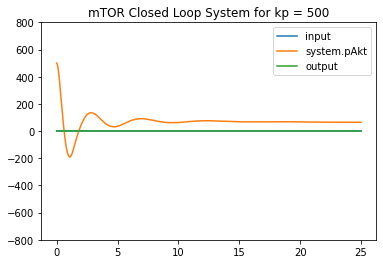

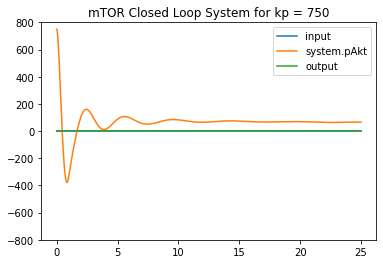

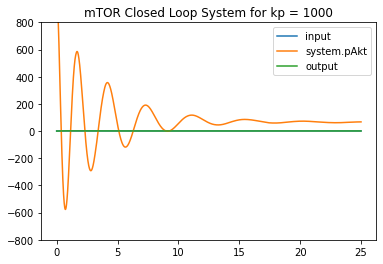

In [41]:
for kps in [500, 750, 1000]:
  plt.figure()
  title="mTOR Closed Loop System for kp = " +str(kps)
  evaluateDesign (model=BIOMD823, input_name="pAkt", output_name="pDEPTOR", kp=kps, ki=0, kd=0, title=title)
  plt.show()

# Q3. Analyze

Construct the transfer function for mTOR from pAkt to pDEPTOR and the transfer function  𝐻𝑁𝑌(𝑠)  for the design parameters you used in (2) (Obtain the Jacobian at time 1 from the open loop mTOR system.) Use these transfer functions to answer the following questions about how the closed loop system should behave in theory.
* Why are large control inputs required to control the mTOR system?
* Why are there no long term oscillations in the closed loop system?
* How will a step increase in noise affect the output of the closed loop system?

In [18]:
HNY = makeHRY(BIOMD823, "HNYs","pAkt", "pDEPTOR", time=1,kp=100)
HNY.dcgain()

-0.5423159826168715

In [20]:
HNY.pole()

array([-5.40085254+0.00000000e+00j, -3.96034236+0.00000000e+00j,
       -1.17057218+0.00000000e+00j, -0.50165764+0.00000000e+00j,
       -0.42857143+0.00000000e+00j, -0.03308986+0.00000000e+00j,
       -0.02      +1.08287694e-09j, -0.02      -1.08287694e-09j])

In [21]:
HNY

TransferFunction(array([-1.00000000e+00, -1.15350860e+01, -4.03050922e+01, -4.61455538e+01,
       -2.21920311e+01, -4.38036571e+00, -2.46627511e-01, -5.28265884e-03,
       -3.86394741e-05]), array([1.00000000e+00, 1.15350860e+01, 4.31986107e+01, 6.05079997e+01,
       3.45132015e+01, 7.69309670e+00, 4.46332457e-01, 9.67842252e-03,
       7.12490048e-05]))

In [24]:
model_jacobian = ctlsb.getJacobian(1)
model_jacobian

,IR,pIR,IRS,pIRS,iIRS,Akt,pAkt,mTORC1,pmTORC1,mTORC2,pmTORC2,imTORC2,mTORC1_DEPTOR,mTORC2_DEPTOR,DEPTOR,pDEPTOR
IR,-0.004619,0.026139,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000,0.000000,0.000000
pIR,0.004619,-0.026139,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000,0.000000,0.000000
IRS,0.000000,-0.066608,-3.557563e-04,0.019791,0.02,0.000000,0.000000,0.000000,-0.066608,0.000000,0.000000,0.0,0.000,0.000,0.000000,0.000000
pIRS,0.000000,0.066608,3.550815e-04,-0.019791,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000,0.000000,0.000000
iIRS,0.000000,0.000000,6.748515e-07,0.000000,-0.02,0.000000,0.000000,0.000000,0.066608,0.000000,0.000000,0.0,0.000,0.000,0.000000,0.000000
Akt,0.000000,0.000000,0.000000e+00,-0.046723,0.00,-0.000031,0.058160,0.000000,0.000000,0.000000,-1.442200,0.0,0.000,0.000,0.000000,0.000000
pAkt,0.000000,0.000000,0.000000e+00,0.046723,0.00,0.000031,-0.058160,0.000000,0.000000,0.000000,1.442200,0.0,0.000,0.000,0.000000,0.000000
mTORC1,0.000000,0.000000,0.000000e+00,0.000000,0.00,0.000000,-0.098652,-0.052828,5.963850,0.000000,0.000000,0.0,0.006,0.000,-0.146370,0.000000
pmTORC1,0.000000,0.000000,0.000000e+00,0.000000,0.00,0.000000,0.098652,0.000002,-5.963850,0.000000,0.000000,0.0,0.000,0.000,0.000000,0.000000
mTORC2,0.000000,-0.011572,0.000000e+00,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,-0.372542,0.423676,0.0,0.000,0.006,-0.044934,0.000000


{'HDYs': TransferFunction(array([1.00000000e+02, 1.15350860e+03, 4.31986107e+03, 6.05079997e+03,
        3.45132015e+03, 7.69309670e+02, 4.46332457e+01, 9.67842252e-01,
        7.12490048e-03]), array([-9.90000000e+01, -1.14197352e+03, -3.98731061e+03, -4.55404738e+03,
        -2.18468991e+03, -4.30343475e+02, -2.42164187e+01, -5.18587461e-01,
        -3.79269840e-03])),
 'HNYs': TransferFunction(array([-1.00000000e+00, -1.15350860e+01, -4.31986107e+01, -6.05079997e+01,
        -3.45132015e+01, -7.69309670e+00, -4.46332457e-01, -9.67842252e-03,
        -7.12490048e-05]), array([-9.90000000e+01, -1.14197352e+03, -3.98731061e+03, -4.55404738e+03,
        -2.18468991e+03, -4.30343475e+02, -2.42164187e+01, -5.18587461e-01,
        -3.79269840e-03])),
 'HREs': TransferFunction(array([1.00000000e+00, 1.15350860e+01, 4.31986107e+01, 6.05079997e+01,
        3.45132015e+01, 7.69309670e+00, 4.46332457e-01, 9.67842252e-03,
        7.12490048e-05]), array([-9.90000000e+01, -1.14197352e+03, -3.9873

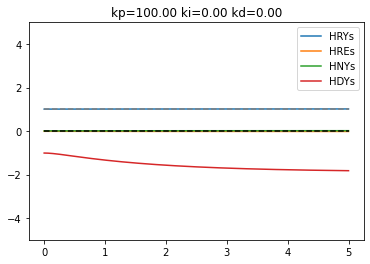

In [22]:
plotTFs(HNY, kp=100, ylim=None, times=TIMES, title="HNY", is_plot=True)


1) Large control inputs for kp are required becasue the mTOR reactions have negative feedback loops that keep the system fairly stable and resistant to pertubations from the steady state

2) All long term oscilations are relatively obsolete because the poles are all negative and are fairly small

3) The DC gain of the noise is 0, and would thus have no effect on the output

# Q4. Discussion

Plot the values of pAkt for the closed loop system you designed in (2). What issues do you see with using this closed loop system in practice?



(sys[22], <control.timeresp.TimeResponseData at 0x7f01c8967810>)

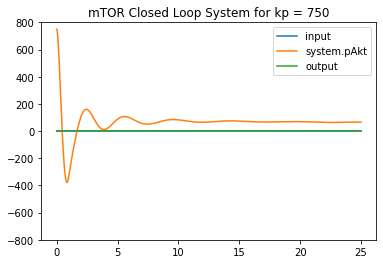

In [43]:
  evaluateDesign (model=BIOMD823, input_name="pAkt", output_name="pDEPTOR", kp=750, ki=0, kd=0, title="mTOR Closed Loop System for kp = 750")

Closed loop systems result in some issues because high values are required to perturb the system, which in turn adds more significant oscillations to the system

Side note: I sent you an email regarding this, but I haven't been as present in class lately due to a family emergency that has been ongoing for the past week. I wasn't sure if you saw the email, so I wanted to add a note here